In [1]:
# Import libraries

import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
# Device selection
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

kwargs = {'num_workers': 1}
if torch.cuda.is_available():
    kwargs['pin_memory'] = True

Using MPS


In [3]:
# Hyperparameters

batch_size = 64
latent_size = 32
init_channels = 8
epochs = 10

In [4]:
# Download the MNIST dataset

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 920kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 7.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.75MB/s]


In [9]:
class VAE(nn.Module):
    def __init__(self, image_channels, init_channels, latent_size):
        super(VAE, self).__init__()
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, init_channels, kernel_size=3, stride=2, padding=1),     # (1, 28, 28) -> (8, 14, 14)
            nn.ReLU(),
            nn.Conv2d(init_channels, init_channels*2, kernel_size=3, stride=2, padding=1),    # (8, 14, 14) -> (16, 7, 7)
            nn.ReLU(),
            nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, stride=2, padding=1),  # (16, 7, 7) -> (32, 4, 4)
            nn.ReLU(),
            nn.Conv2d(init_channels*4, 64, kernel_size=3, stride=1, padding=0),               # (32, 4, 4) -> (64, 2, 2)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=0),                            # (64, 2, 2) -> (64, 1, 1)
            nn.ReLU()
        )
        
        # FC layers to get mu and logvar
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_size)
        self.fc_logvar = nn.Linear(128, latent_size)
        self.fc2 = nn.Linear(latent_size, 64)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=1, padding=0),                  # (64, 1, 1) -> (64, 2, 2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, init_channels*4, kernel_size=3, stride=1, padding=0),  # (64, 2, 2) -> (32, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels*4, init_channels*2, kernel_size=3, stride=2, padding=1),  # (32, 4, 4) -> (16, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels*2, init_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16, 7, 7) -> (8, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels, image_channels, kernel_size=4, stride=2, padding=1)  # (8, 14, 14) -> (1, 28, 28)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)        
        h_fc = F.relu(self.fc1(h))
        mu = self.fc_mu(h_fc)
        logvar = self.fc_logvar(h_fc)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sample = mu + eps * std
        return sample
    
    def decode(self, z):
        h = F.relu(self.fc2(z))
        h = h.view(-1, 64, 1, 1)
        
        return torch.sigmoid(self.decoder(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [10]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction + KL divergence losses summed over all elements and batch
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # -0.5 * torch.sum(1 + log(sigma^2) - mu^2 - sigma^2)2
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [11]:
# Train and Test functions
def train(model, optimizer, epoch, losses):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    
    losses.append(train_loss / len(train_loader.dataset))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(model, epoch, losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
            if i == 0:
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(-1, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'reconstruction_' + str(f"{epoch:02}") + '.png', nrow=n)

    losses.append(test_loss / len(test_loader.dataset))
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [12]:
model = VAE(image_channels=1, init_channels=init_channels, latent_size=latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_losses)
    test(model, epoch, test_losses)
    with torch.no_grad():
        sample = torch.randn(10, latent_size).to(device)
        sample = model.decode(sample).to(device)
        save_image(sample.view(10, 1, 28, 28), str(f"sample_{epoch:02}.png"))

Train Epoch: 1 [0/60000 (0%)]	Loss: 507.688263
Train Epoch: 1 [1280/60000 (2%)]	Loss: 483.862457
Train Epoch: 1 [2560/60000 (4%)]	Loss: 346.612701
Train Epoch: 1 [3840/60000 (6%)]	Loss: 228.238892
Train Epoch: 1 [5120/60000 (9%)]	Loss: 203.408539
Train Epoch: 1 [6400/60000 (11%)]	Loss: 210.141479
Train Epoch: 1 [7680/60000 (13%)]	Loss: 218.633865
Train Epoch: 1 [8960/60000 (15%)]	Loss: 204.745331
Train Epoch: 1 [10240/60000 (17%)]	Loss: 206.797760
Train Epoch: 1 [11520/60000 (19%)]	Loss: 211.760010
Train Epoch: 1 [12800/60000 (21%)]	Loss: 204.310211
Train Epoch: 1 [14080/60000 (23%)]	Loss: 216.208206
Train Epoch: 1 [15360/60000 (26%)]	Loss: 194.319901
Train Epoch: 1 [16640/60000 (28%)]	Loss: 195.802933
Train Epoch: 1 [17920/60000 (30%)]	Loss: 203.909256
Train Epoch: 1 [19200/60000 (32%)]	Loss: 201.647964
Train Epoch: 1 [20480/60000 (34%)]	Loss: 193.300720
Train Epoch: 1 [21760/60000 (36%)]	Loss: 185.980026
Train Epoch: 1 [23040/60000 (38%)]	Loss: 198.485275
Train Epoch: 1 [24320/60000 

[np.float32(205.86311), np.float32(155.6941), np.float32(142.68568), np.float32(137.19875), np.float32(134.44656), np.float32(132.38966), np.float32(130.53625), np.float32(127.91588), np.float32(125.49201), np.float32(124.191826)]
[np.float32(169.74904), np.float32(146.91347), np.float32(138.87427), np.float32(136.12633), np.float32(133.50252), np.float32(132.55455), np.float32(129.04135), np.float32(126.632576), np.float32(125.13667), np.float32(123.025635)]


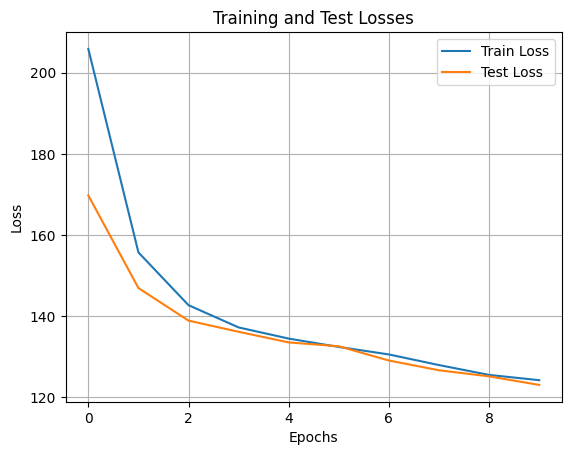

In [13]:
# Visualize the training and test losses
import matplotlib.pyplot as plt
print(train_losses)
print(test_losses)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Save the model
import torchvision.models as models

torch.save(model.state_dict(), 'vae_model_mnist.pth' )

In [ ]:
# Load the model

model = VAE(image_channels=1, init_channels=init_channels, latent_size=latent_size).to(device)
model.load_state_dict(torch.load('vae_model_mnist.pth'))

In [26]:
# Test the model

def generate_digit(model, num_samples=1):
    model.eval()
    with torch.no_grad():
        sample = torch.randn(num_samples, latent_size).to(device)
        sample = model.decode(sample).to(device)
        
        save_image(sample.view(num_samples, 1, 28, 28), f"generated_sample.png")

generate_digit(model, num_samples=8)